# Experiments
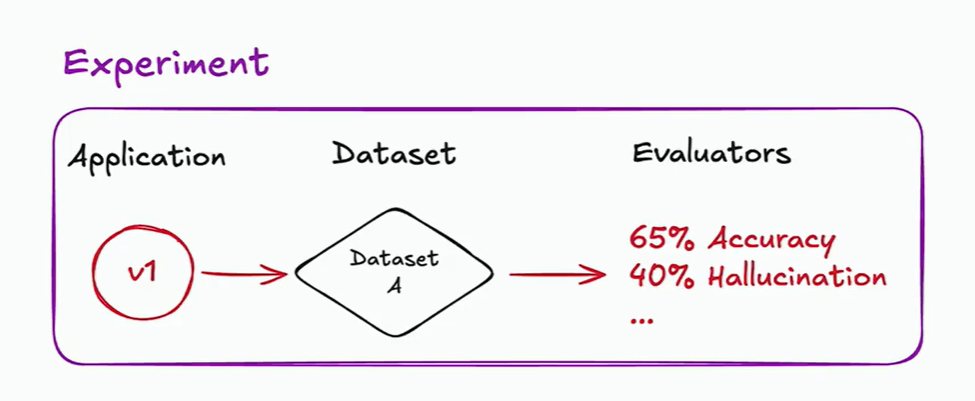

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

Here is the RAG Application that we've been working with throughout this course

In [3]:
import os
import tempfile
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders.sitemap import SitemapLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings
from langsmith import traceable
from openai import OpenAI
from typing import List
import nest_asyncio

# configured this model!
MODEL_NAME = "gpt-4o"
MODEL_PROVIDER = "openai"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

openai_client = OpenAI()

def get_vector_db_retriever():
    persist_path = os.path.join(tempfile.gettempdir(), "union.parquet")
    embd = OpenAIEmbeddings()

    # If vector store exists, then load it
    if os.path.exists(persist_path):
        vectorstore = SKLearnVectorStore(
            embedding=embd,
            persist_path=persist_path,
            serializer="parquet"
        )
        return vectorstore.as_retriever(lambda_mult=0)

    # Otherwise, index LangSmith documents and create new vector store
    ls_docs_sitemap_loader = SitemapLoader(web_path="https://docs.smith.langchain.com/sitemap.xml", continue_on_failure=True)
    ls_docs = ls_docs_sitemap_loader.load()

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=500, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(ls_docs)

    vectorstore = SKLearnVectorStore.from_documents(
        documents=doc_splits,
        embedding=embd,
        persist_path=persist_path,
        serializer="parquet"
    )
    vectorstore.persist()
    return vectorstore.as_retriever(lambda_mult=0)

nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

"""
generate_response
- Calls `call_openai` to generate a model response after formatting inputs
"""
@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

"""
call_openai
- Returns the chat completion output from OpenAI
"""
@traceable(
    run_type="llm",
    metadata={
        "ls_provider": MODEL_PROVIDER,
        "ls_model_name": MODEL_NAME
    }
)
def call_openai(messages: List[dict]) -> str:
    return openai_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )

"""
langsmith_rag
- Calls `retrieve_documents` to fetch documents
- Calls `generate_response` to generate a response based on the fetched documents
- Returns the model response
"""
@traceable(run_type="chain")
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content

USER_AGENT environment variable not set, consider setting it to identify your requests.


### Experiment
Two key components:
* Defined an Evaluator - function that scores LLM output
* Target function - transforms dataset examples (dict format) into the input shape your langsmith_rag function expects (string format)

This pipeline ensures dataset examples match your function's input requirements before evaluation.

In [6]:
from langsmith import evaluate, Client

client = Client()
dataset_name = "RAG-application-golden-dataset"

def is_concise_enough(reference_outputs: dict, outputs: dict) -> dict:
    score = len(outputs["output"]) < 1.5 * len(reference_outputs["output"])
    return {"key": "is_concise", "score": int(score)}

def target_function(inputs: dict):
    return langsmith_rag(inputs["question"])

evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="gpt-4o"
)

c:\Users\palle\anaconda3\envs\MAT496\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


View the evaluation results for experiment: 'gpt-4o-3dd10818' at:
https://smith.langchain.com/o/90a87341-c5d0-4c68-b120-c011e2a9c3ef/datasets/97edac70-e67f-46ce-a5d7-caf3c6971d5c/compare?selectedSessions=5bef727d-da4e-4fb4-806e-c72085a5887e




16it [00:45,  2.86s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,4.309857,07f7ec6e-385c-445d-826a-d80949611198,2bc0e84f-dffe-49fe-b961-914cfae82102
1,What testing capabilities does LangSmith have?,LangSmith allows users to run multiple experim...,None,LangSmith offers capabilities for creating dat...,1,4.087588,1b222759-e023-4b84-b800-a456cb93b578,a3d2a8ad-2f43-46ee-b7bd-48c23d80215b
2,How do I pass metadata in with @traceable?,You can pass metadata in with `@traceable` by ...,None,You can pass metadata with the @traceable deco...,1,3.666710,275018d9-6d84-4e80-b3e5-6e1d4c9afe5a,750d2f08-923d-4603-80e1-31a6c9db05d8
3,Is there a mobile version of LangSmith?,The provided context does not mention a mobile...,None,"No, LangSmith does not currently have a mobile...",1,1.654446,2dbf50ae-1819-4462-8c59-86cba1cdb119,040c3b0c-4218-4bec-a277-f32e34cdf8b0
4,Does LangSmith support online evaluation?,"Yes, LangSmith supports online evaluation. It ...",None,"Yes, LangSmith supports online evaluation as a...",1,2.421208,ae074174-b625-4c41-b245-5523ce689169,83c1c9f5-eabb-4c1c-bae1-ced533d5fe47
5,Can LangSmith be used for finetuning and model...,"No, LangSmith is designed for monitoring, eval...",None,"Yes, LangSmith can be used for fine-tuning and...",1,2.863948,b90da1e2-e94b-48e1-9038-aec4c2c40294,03944f3e-f714-4eca-b41a-db4f1484bd1d
6,What is LangSmith used for in three sentences?,LangSmith is a platform designed for building ...,None,LangSmith is a platform designed for the devel...,1,2.967662,e6515699-7d1c-4650-89db-ff9cefacaed1,39fa3aea-cc09-4c67-b6d0-b5b61e5f5603
7,What are the main benefits of using LangSmith ...,The main benefits of using LangSmith for AI ap...,None,The main benefits of using LangSmith for AI ap...,0,2.747529,facc082a-3a7e-4bd6-aea8-39582e603603,79b7f041-b6f4-47bc-b2b2-f753ee455606
8,Can I integrate LangSmith with other programmi...,The provided context specifies integration wit...,None,"Yes, LangSmith offers API access and can be in...",0,1.850863,40ae19fa-642c-4b8d-b5af-d125bcb72f50,2ce06405-0a4b-4a57-9a3e-53011ed72ebf
9,What kind of user support does LangSmith offer?,LangSmith offers user support through video tu...,None,"LangSmith offers comprehensive user support, i...",1,2.960477,3f6f9b06-59f4-4e8e-9857-6c7ffdb9ad83,658186de-f3bb-4952-a937-79b45dc3efe6


### Modifying your application

Now, let's change our model to gpt-35-turbo and see how it performs!

Make this change, and then run the code snippet!

In [7]:

from langsmith import evaluate, Client
from langsmith.schemas import Example, Run

def target_function(inputs: dict):
    return langsmith_rag(inputs["question"])

evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="gpt-3.5-turbo"
)

View the evaluation results for experiment: 'gpt-3.5-turbo-7595035e' at:
https://smith.langchain.com/o/90a87341-c5d0-4c68-b120-c011e2a9c3ef/datasets/97edac70-e67f-46ce-a5d7-caf3c6971d5c/compare?selectedSessions=11408cfe-785f-4adc-9485-52b86d451c79




16it [00:41,  2.57s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,2.164444,07f7ec6e-385c-445d-826a-d80949611198,9ed19c6f-cd45-491c-8fa0-34489116a6b0
1,What testing capabilities does LangSmith have?,LangSmith offers the capability to run multipl...,None,LangSmith offers capabilities for creating dat...,1,2.232965,1b222759-e023-4b84-b800-a456cb93b578,6b63c453-c522-44fa-99dd-451e535e7d23
2,How do I pass metadata in with @traceable?,To pass metadata with the `@traceable` decorat...,None,You can pass metadata with the @traceable deco...,1,2.938867,275018d9-6d84-4e80-b3e5-6e1d4c9afe5a,6edce03d-f364-460d-9d41-0457f523114c
3,Is there a mobile version of LangSmith?,The available information does not specify whe...,None,"No, LangSmith does not currently have a mobile...",1,1.408929,2dbf50ae-1819-4462-8c59-86cba1cdb119,60da9574-34fe-4bf6-83c4-e176ada71a7c
4,Does LangSmith support online evaluation?,"Yes, LangSmith supports online evaluation. It ...",None,"Yes, LangSmith supports online evaluation as a...",1,3.634606,ae074174-b625-4c41-b245-5523ce689169,51083ec4-9ff4-4ba7-8151-63122f57d619
5,Can LangSmith be used for finetuning and model...,"No, LangSmith is not designed for finetuning a...",None,"Yes, LangSmith can be used for fine-tuning and...",1,1.982278,b90da1e2-e94b-48e1-9038-aec4c2c40294,a7cda106-5446-4d77-82bf-5e7d85247363
6,What is LangSmith used for in three sentences?,LangSmith is a platform designed for building ...,None,LangSmith is a platform designed for the devel...,1,3.071596,e6515699-7d1c-4650-89db-ff9cefacaed1,a751d9c8-62d1-4cb5-9d27-8c852e874621
7,What are the main benefits of using LangSmith ...,LangSmith provides enhanced observability and ...,None,The main benefits of using LangSmith for AI ap...,1,2.641712,facc082a-3a7e-4bd6-aea8-39582e603603,30ac82aa-ee03-4724-b377-b8b0206f59d1
8,Can I integrate LangSmith with other programmi...,The provided context only mentions integration...,None,"Yes, LangSmith offers API access and can be in...",1,2.015959,40ae19fa-642c-4b8d-b5af-d125bcb72f50,b72ffd77-6f50-4a4e-a6cc-3b266d4020cb
9,What kind of user support does LangSmith offer?,LangSmith offers user support through video tu...,None,"LangSmith offers comprehensive user support, i...",1,2.217635,3f6f9b06-59f4-4e8e-9857-6c7ffdb9ad83,6042b185-76e0-4dc9-98a1-decbaff63a6b


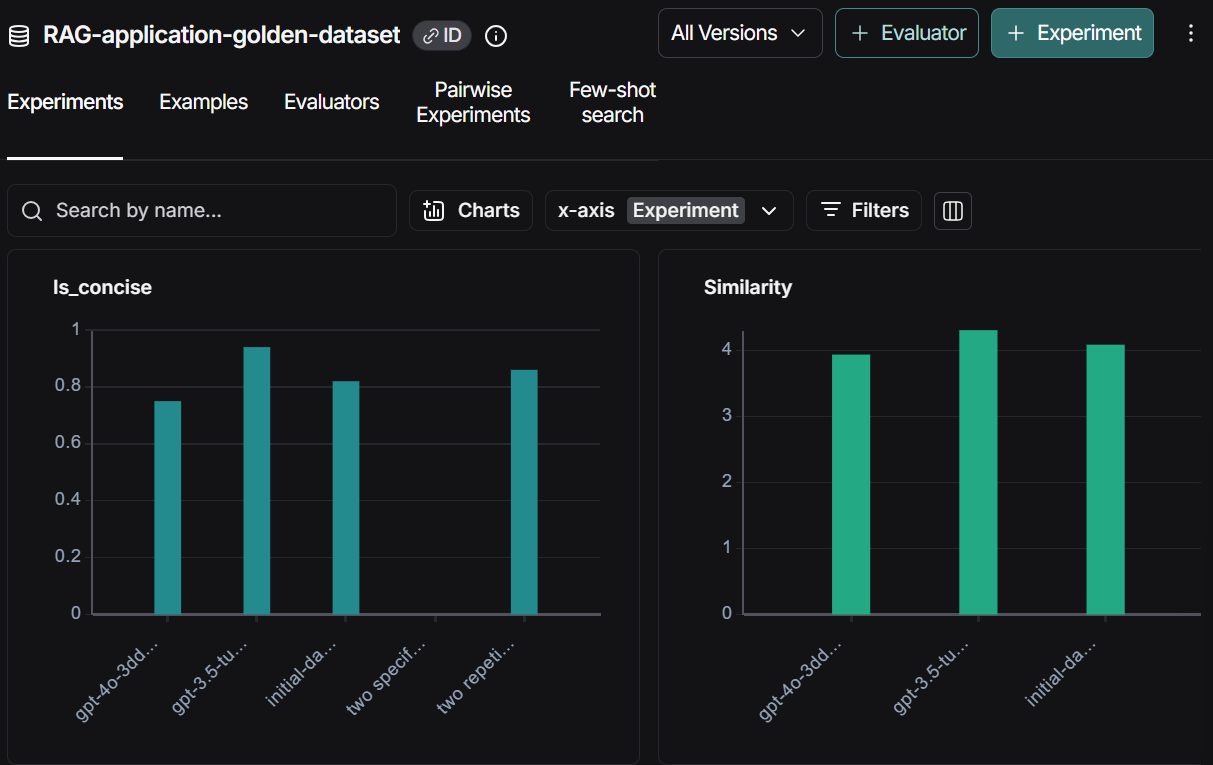

### Running over Different pieces of Data

Dataset Version
You can execute an experiment on a specific version of a dataset in the sdk by using the as_of parameter in list_examples

Let's try running on just our initial dataset.

In [14]:

evaluate(
    target_function,
    data=client.list_examples(dataset_name=dataset_name, as_of="initial-dataset"),   # We use as_of to specify a version
    evaluators=[is_concise_enough],
    experiment_prefix="initial-dataset"
)

View the evaluation results for experiment: 'initial-dataset-4c5825d8' at:
https://smith.langchain.com/o/90a87341-c5d0-4c68-b120-c011e2a9c3ef/datasets/97edac70-e67f-46ce-a5d7-caf3c6971d5c/compare?selectedSessions=7dc89308-4a04-4d75-9776-552f08b79ce3




11it [00:32,  2.92s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,"Hey this is Viraja, Do you think I like ice cr...",I can't determine if you like ice creams witho...,None,"I don't know if you like ice creams, but LangC...",1,3.675960,0829491e-6853-4cf3-9725-b6648a463aec,bfd3deb1-f904-4543-bf0e-3fab40f7488f
1,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,2.658027,07f7ec6e-385c-445d-826a-d80949611198,6328f6ca-a821-41ae-93e5-6d22eaf873d9
2,What testing capabilities does LangSmith have?,LangSmith offers the capability to run multipl...,None,LangSmith offers capabilities for creating dat...,1,2.293907,1b222759-e023-4b84-b800-a456cb93b578,1342323a-acf2-4901-b48a-47f75c72327c
3,How do I set up tracing to LangSmith if I'm us...,"To set up tracing to LangSmith with LangChain,...",None,To set up tracing to LangSmith while using Lan...,0,2.712557,1ddac1e1-12cf-4dd6-80f8-9816fde81342,d7c2190d-8651-4aba-bac2-5e2434a84d41
4,How can I trace with the @traceable decorator?,To trace with the @traceable decorator in Pyth...,None,To trace with the @traceable decorator in Pyth...,1,2.752357,21323396-d1b8-4542-a58a-ddaebd84c19f,4c9c06b8-5c35-4c40-b605-e2e6eee2f050
5,How do I pass metadata in with @traceable?,"To pass metadata with `@traceable`, you can in...",None,You can pass metadata with the @traceable deco...,0,3.353829,275018d9-6d84-4e80-b3e5-6e1d4c9afe5a,cbe6e8b0-ceba-4669-97d2-19eb5587842c
6,Does LangSmith support offline evaluation?,The provided context does not mention offline ...,None,"Yes, LangSmith supports offline evaluation thr...",1,2.962425,9e1bec49-1e72-4fa1-96fa-61e904dacc07,411bf95f-c322-4d94-bc2c-fdb807133316
7,Does LangSmith support online evaluation?,"Yes, LangSmith supports online evaluations. Th...",None,"Yes, LangSmith supports online evaluation as a...",1,2.445098,ae074174-b625-4c41-b245-5523ce689169,380effb6-fc9c-455f-ba79-0abf1263bc68
8,Can LangSmith be used for finetuning and model...,"No, LangSmith is not designed for finetuning o...",None,"Yes, LangSmith can be used for fine-tuning and...",1,3.580573,b90da1e2-e94b-48e1-9038-aec4c2c40294,8e782fe1-bf70-4efa-bc34-d7cce50815e8
9,What is LangSmith used for in three sentences?,LangSmith is used for building and managing pr...,None,LangSmith is a platform designed for the devel...,1,2.481655,e6515699-7d1c-4650-89db-ff9cefacaed1,bb8ad45c-c5f0-449a-b1f5-8232f67fd6d6


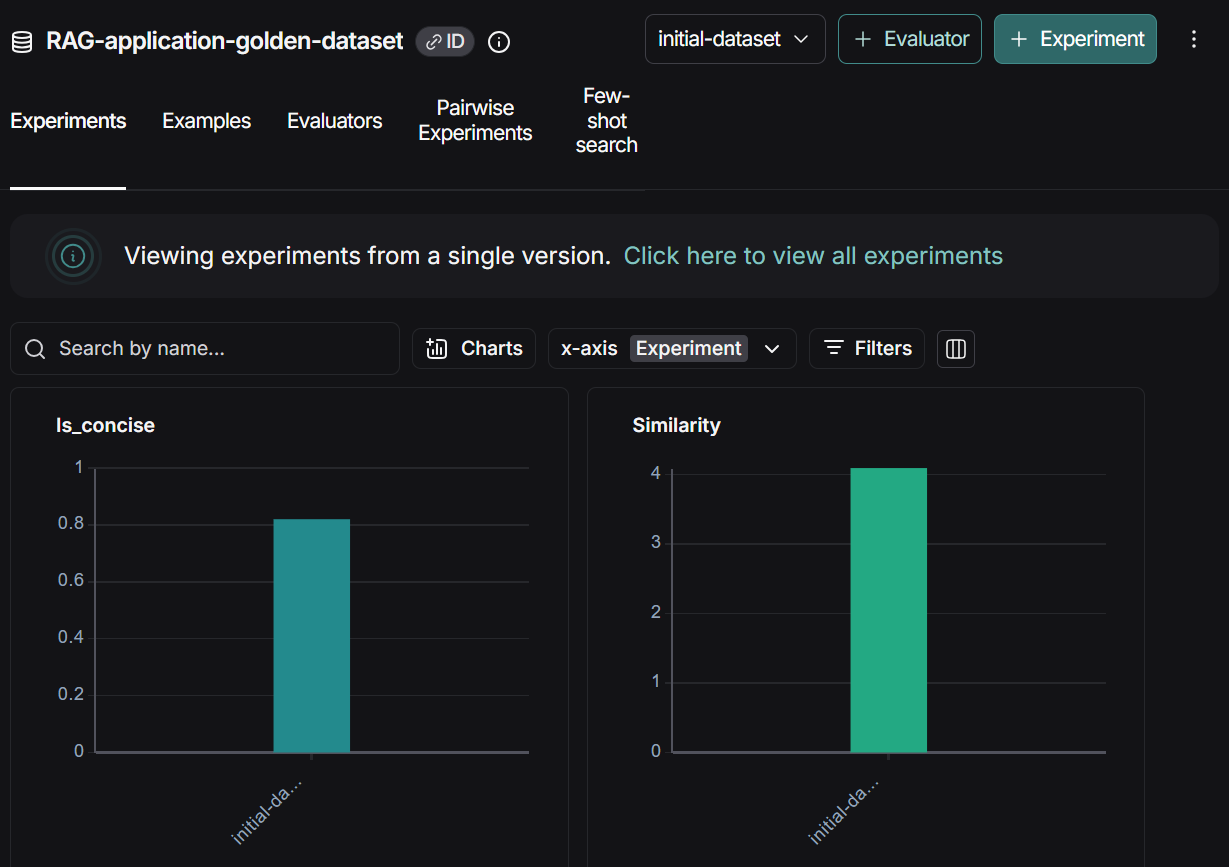

Dataset Split:
You can run an experiment on a specific split of your dataset, let's try running on the Crucial Examples split.

In [22]:
evaluate(
    target_function,
    data=client.list_examples(dataset_name=dataset_name, as_of = "crucial split dataset"),  # We pass in a list of Splits
    evaluators=[is_concise_enough],
    experiment_prefix="crucial split dataset"
)

View the evaluation results for experiment: 'crucial split dataset-442b51ac' at:
https://smith.langchain.com/o/90a87341-c5d0-4c68-b120-c011e2a9c3ef/datasets/97edac70-e67f-46ce-a5d7-caf3c6971d5c/compare?selectedSessions=9a420042-b224-426d-a3fb-4b1eb05dab25




14it [00:37,  2.65s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,Is there a mobile version of LangSmith?,The provided context doesn't mention a mobile ...,None,"No, LangSmith does not currently have a mobile...",1,1.899646,2dbf50ae-1819-4462-8c59-86cba1cdb119,d12ddaf8-e57e-4b02-a218-fbeb1274bd2b
1,What kind of user support does LangSmith offer?,LangSmith offers user support through video tu...,None,"LangSmith offers comprehensive user support, i...",1,2.732950,3f6f9b06-59f4-4e8e-9857-6c7ffdb9ad83,03d6af98-aabf-43eb-a103-123c05a938f7
2,Is there a JS LangSmith SDK?,"Yes, there is a JavaScript/TypeScript SDK for ...",None,Yes,0,1.244552,84586c23-f179-44ac-b441-5a35ae43209c,4df7c588-2a21-47d9-a259-f8ea86ee7b7a
3,"Hey this is Viraja, Do you think I like ice cr...","I can't determine your personal preferences, s...",None,"I don't know if you like ice creams, but LangC...",1,2.961127,0829491e-6853-4cf3-9725-b6648a463aec,ea8abb40-78ac-4d56-a274-c2b3b5396ea7
4,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,2.435047,07f7ec6e-385c-445d-826a-d80949611198,2204c22a-59e8-4f73-9d53-0a89b5dbe493
5,What testing capabilities does LangSmith have?,LangSmith allows users to run multiple experim...,None,LangSmith offers capabilities for creating dat...,1,1.755290,1b222759-e023-4b84-b800-a456cb93b578,c2ed05d8-e5aa-4c37-99cd-07b97d624378
6,How do I set up tracing to LangSmith if I'm us...,To set up tracing to LangSmith using LangChain...,None,To set up tracing to LangSmith while using Lan...,1,3.253304,1ddac1e1-12cf-4dd6-80f8-9816fde81342,f4ef73b8-dcef-439b-97a0-3dc3dc868fd6
7,How can I trace with the @traceable decorator?,"To trace with the @traceable decorator, you si...",None,To trace with the @traceable decorator in Pyth...,1,4.007111,21323396-d1b8-4542-a58a-ddaebd84c19f,6ff829a6-eebb-4e09-a4e6-f10a56923a5d
8,How do I pass metadata in with @traceable?,You can pass metadata in with `@traceable` by ...,None,You can pass metadata with the @traceable deco...,1,2.964259,275018d9-6d84-4e80-b3e5-6e1d4c9afe5a,ddafcf1d-e172-4a9e-acd1-566b136d130a
9,Does LangSmith support offline evaluation?,The provided context does not explicitly menti...,None,"Yes, LangSmith supports offline evaluation thr...",1,2.332758,9e1bec49-1e72-4fa1-96fa-61e904dacc07,961b6fb0-29b6-44af-8067-5c4a70fa60ec



Specific Data Points: 
You can specify individual data points to run an experiment over as well

In [17]:

evaluate(
    target_function,
    data=client.list_examples(
        dataset_name=dataset_name, 
        example_ids=[   # We pass in a specific list of example_ids
            #  own example ids for this to work!
            "84586c23-f179-44ac-b441-5a35ae43209c",
            "1ddac1e1-12cf-4dd6-80f8-9816fde81342"
        ]
    ),
    evaluators=[is_concise_enough],
    experiment_prefix="two specific example ids"
)

View the evaluation results for experiment: 'two specific example ids-bb8bbc4d' at:
https://smith.langchain.com/o/90a87341-c5d0-4c68-b120-c011e2a9c3ef/datasets/97edac70-e67f-46ce-a5d7-caf3c6971d5c/compare?selectedSessions=f9227fb1-696d-4145-a140-69ab60203c71




2it [00:11,  5.75s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,How do I set up tracing to LangSmith if I'm us...,To set up tracing to LangSmith using LangChain...,None,To set up tracing to LangSmith while using Lan...,0,8.793943,1ddac1e1-12cf-4dd6-80f8-9816fde81342,c8763954-013d-42c7-b01c-5bfa6a2df587
1,Is there a JS LangSmith SDK?,"Yes, there is a LangSmith SDK for JavaScript/T...",None,Yes,0,2.134707,84586c23-f179-44ac-b441-5a35ae43209c,2c6b5c49-229e-4870-8450-6c19f7171891


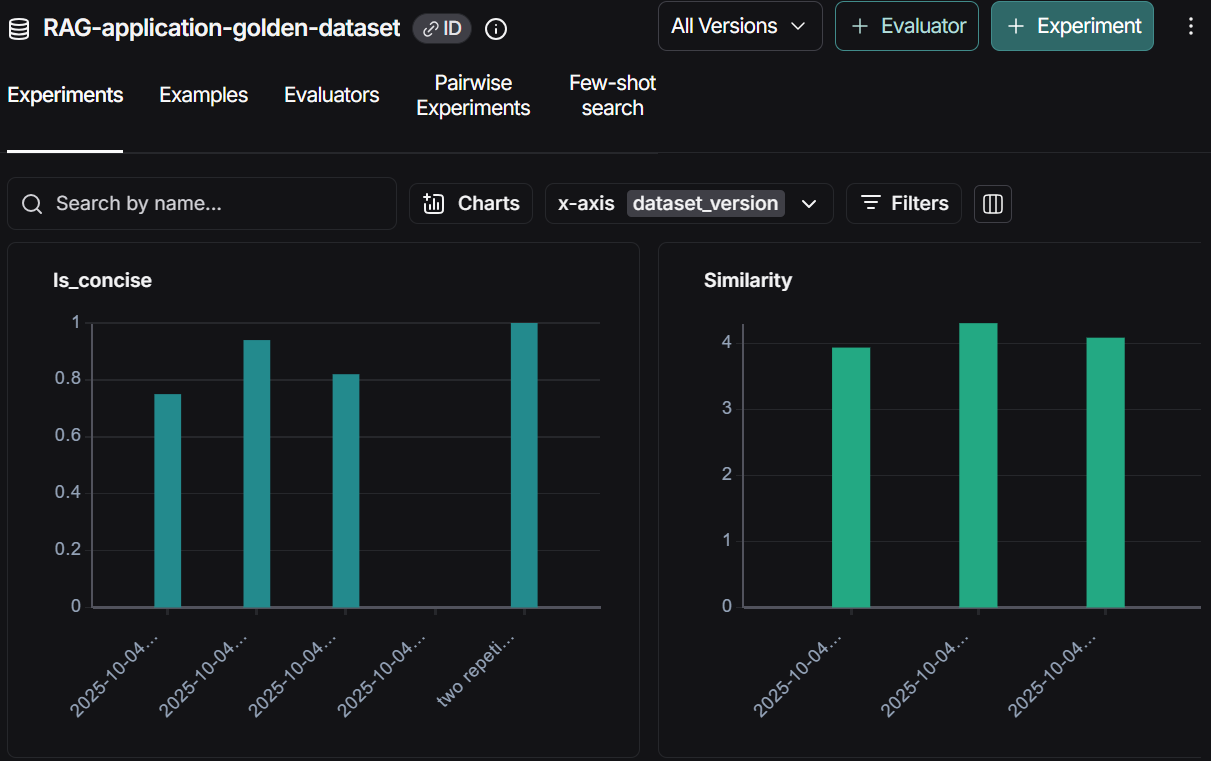

### Other parameters
Repetitions: 
You can run an experiment several times to make sure you have consistent results

In [18]:

evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="two repetitions",
    num_repetitions=2   # This field defaults to 1
)

View the evaluation results for experiment: 'two repetitions-751a7053' at:
https://smith.langchain.com/o/90a87341-c5d0-4c68-b120-c011e2a9c3ef/datasets/97edac70-e67f-46ce-a5d7-caf3c6971d5c/compare?selectedSessions=c258338e-b53b-4b8f-b3c2-ed07284c9bd1




32it [01:18,  2.45s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,2.561282,07f7ec6e-385c-445d-826a-d80949611198,3fc1b311-a8ac-41a7-a4fb-5115cdec4dcb
1,What testing capabilities does LangSmith have?,LangSmith allows you to run multiple experimen...,None,LangSmith offers capabilities for creating dat...,1,2.941880,1b222759-e023-4b84-b800-a456cb93b578,539f225a-49e3-490b-9c36-6a19a70e9595
2,How do I pass metadata in with @traceable?,To pass metadata with the `@traceable` decorat...,None,You can pass metadata with the @traceable deco...,1,4.196453,275018d9-6d84-4e80-b3e5-6e1d4c9afe5a,0a9f76de-0e95-4a07-b91c-d544d2a755ef
3,Is there a mobile version of LangSmith?,I don't know.,None,"No, LangSmith does not currently have a mobile...",1,1.533395,2dbf50ae-1819-4462-8c59-86cba1cdb119,ad3d0515-04fe-4960-aad3-b9ec04c90603
4,Does LangSmith support online evaluation?,"Yes, LangSmith supports online evaluation. It ...",None,"Yes, LangSmith supports online evaluation as a...",1,2.160517,ae074174-b625-4c41-b245-5523ce689169,0c0a827f-c5e5-460e-93a5-4f7d2b039b42
5,Can LangSmith be used for finetuning and model...,LangSmith is designed for observability and ev...,None,"Yes, LangSmith can be used for fine-tuning and...",1,2.636545,b90da1e2-e94b-48e1-9038-aec4c2c40294,662cb6d3-fd81-469a-9818-bff09f4393b0
6,What is LangSmith used for in three sentences?,LangSmith is a platform for building productio...,None,LangSmith is a platform designed for the devel...,1,2.656703,e6515699-7d1c-4650-89db-ff9cefacaed1,88bd65f0-635e-40f6-a072-b57847dd4dc2
7,What are the main benefits of using LangSmith ...,LangSmith offers several benefits for AI appli...,None,The main benefits of using LangSmith for AI ap...,0,2.132537,facc082a-3a7e-4bd6-aea8-39582e603603,96469735-1ccf-42b3-96fd-157479523722
8,Can I integrate LangSmith with other programmi...,LangSmith integrates seamlessly with LangChain...,None,"Yes, LangSmith offers API access and can be in...",1,2.174074,40ae19fa-642c-4b8d-b5af-d125bcb72f50,c7d42b74-26c4-4832-9aa6-791cbb58031f
9,What kind of user support does LangSmith offer?,LangSmith offers user support in the form of v...,None,"LangSmith offers comprehensive user support, i...",1,2.438069,3f6f9b06-59f4-4e8e-9857-6c7ffdb9ad83,cdc758fd-f0e6-4ce1-becd-739b1874ec79



Concurrency: 
You can also kick off concurrent threads of execution to make your experiments finish faster!

In [19]:

evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="concurrency",
    max_concurrency=3,  # This defaults to None, so this is an improvement!
)

View the evaluation results for experiment: 'concurrency-d675cfe0' at:
https://smith.langchain.com/o/90a87341-c5d0-4c68-b120-c011e2a9c3ef/datasets/97edac70-e67f-46ce-a5d7-caf3c6971d5c/compare?selectedSessions=bd723bb5-0b8d-4510-a361-e478b69b173b




16it [00:14,  1.13it/s]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,1.877321,07f7ec6e-385c-445d-826a-d80949611198,f84d133e-0354-44ad-9213-2e0fed26cada
1,What testing capabilities does LangSmith have?,LangSmith allows you to run multiple experimen...,None,LangSmith offers capabilities for creating dat...,1,2.659622,1b222759-e023-4b84-b800-a456cb93b578,8b0fe59f-7a2d-4e10-a95d-ffa794311509
2,How do I pass metadata in with @traceable?,"To pass metadata in with `@traceable`, you can...",None,You can pass metadata with the @traceable deco...,1,2.655129,275018d9-6d84-4e80-b3e5-6e1d4c9afe5a,5ce78489-18cb-4f12-b7c6-4eca54d6d1fb
3,Is there a mobile version of LangSmith?,I don't know.,None,"No, LangSmith does not currently have a mobile...",1,1.213970,2dbf50ae-1819-4462-8c59-86cba1cdb119,0e2cd5ed-6ded-4157-9fc0-5788929ccb68
4,Can LangSmith be used for finetuning and model...,LangSmith is primarily a platform for LLM obse...,None,"Yes, LangSmith can be used for fine-tuning and...",1,2.038117,b90da1e2-e94b-48e1-9038-aec4c2c40294,becdf1fe-9dbc-4040-97b5-93b8a8d0c80a
5,Does LangSmith support online evaluation?,"Yes, LangSmith supports online evaluation thro...",None,"Yes, LangSmith supports online evaluation as a...",1,2.711350,ae074174-b625-4c41-b245-5523ce689169,ed8df874-6e70-4192-ab62-b207ebd5c3e0
6,What is LangSmith used for in three sentences?,LangSmith is a platform for building productio...,None,LangSmith is a platform designed for the devel...,1,2.787051,e6515699-7d1c-4650-89db-ff9cefacaed1,9fbb9c25-2c73-44f2-89c3-dc50773e3c5b
7,Can I integrate LangSmith with other programmi...,"No, LangSmith integrates specifically with Lan...",None,"Yes, LangSmith offers API access and can be in...",1,1.903529,40ae19fa-642c-4b8d-b5af-d125bcb72f50,163f66dc-871e-404f-985c-a9c4b8baa9fc
8,What are the main benefits of using LangSmith ...,The main benefits of using LangSmith for AI ap...,None,The main benefits of using LangSmith for AI ap...,0,2.726506,facc082a-3a7e-4bd6-aea8-39582e603603,57272d82-e295-40dd-8d72-aceef30a2d03
9,What kind of user support does LangSmith offer?,LangSmith offers video tutorials as part of th...,None,"LangSmith offers comprehensive user support, i...",0,2.561025,3f6f9b06-59f4-4e8e-9857-6c7ffdb9ad83,2033f61b-71f1-4c55-9ced-709e42346499



Metadata: 
You can (and should) add metadata to your experiments, to make them easier to find in the UI

In [20]:
evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="metadata added",
    metadata={  # We can pass custom metadata for the experiment, such as the model name
        "model_name": MODEL_NAME
    }
)

View the evaluation results for experiment: 'metadata added-a6843e2c' at:
https://smith.langchain.com/o/90a87341-c5d0-4c68-b120-c011e2a9c3ef/datasets/97edac70-e67f-46ce-a5d7-caf3c6971d5c/compare?selectedSessions=25f54bd8-d67a-4167-88b9-a3fef90b3a96




16it [00:37,  2.37s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,2.260333,07f7ec6e-385c-445d-826a-d80949611198,2fb4a228-52cc-474d-b543-ff4d5773cd8e
1,What testing capabilities does LangSmith have?,LangSmith allows you to run multiple experimen...,None,LangSmith offers capabilities for creating dat...,1,1.862570,1b222759-e023-4b84-b800-a456cb93b578,40abf194-cd00-4873-b652-8456bdf9901c
2,How do I pass metadata in with @traceable?,"To pass metadata with `@traceable`, you need t...",None,You can pass metadata with the @traceable deco...,1,2.912450,275018d9-6d84-4e80-b3e5-6e1d4c9afe5a,448b27df-361e-4dc3-b063-92f28c673ea7
3,Is there a mobile version of LangSmith?,The provided context does not mention a mobile...,None,"No, LangSmith does not currently have a mobile...",1,1.359852,2dbf50ae-1819-4462-8c59-86cba1cdb119,3ba84479-243e-4352-b05a-0eeadfdc1e24
4,Does LangSmith support online evaluation?,"Yes, LangSmith supports online evaluation, whi...",None,"Yes, LangSmith supports online evaluation as a...",1,2.419100,ae074174-b625-4c41-b245-5523ce689169,c3a794e4-c2a6-42a0-8d00-6fd81e4b3d36
5,Can LangSmith be used for finetuning and model...,"LangSmith is designed for LLM observability, e...",None,"Yes, LangSmith can be used for fine-tuning and...",1,2.566111,b90da1e2-e94b-48e1-9038-aec4c2c40294,900abd3b-802d-4e37-a3e6-43a0eb462558
6,What is LangSmith used for in three sentences?,LangSmith is a platform designed for building ...,None,LangSmith is a platform designed for the devel...,1,2.137390,e6515699-7d1c-4650-89db-ff9cefacaed1,fcdaad4a-fd39-4ddd-a48c-7a0cec6efd38
7,What are the main benefits of using LangSmith ...,The main benefits of using LangSmith for AI ap...,None,The main benefits of using LangSmith for AI ap...,0,3.061479,facc082a-3a7e-4bd6-aea8-39582e603603,4eb3be59-7a14-47a0-b652-178e41fc2156
8,Can I integrate LangSmith with other programmi...,The context provided mentions integration with...,None,"Yes, LangSmith offers API access and can be in...",1,1.858235,40ae19fa-642c-4b8d-b5af-d125bcb72f50,f0b368ae-be9a-4d48-8e99-62c00edace94
9,What kind of user support does LangSmith offer?,LangSmith offers user support through resource...,None,"LangSmith offers comprehensive user support, i...",1,3.096646,3f6f9b06-59f4-4e8e-9857-6c7ffdb9ad83,12a3e79e-2a9d-45da-ad1a-f4feebd2b0f4
